# **PROJECT-3. EDA + Feature Engineering.**

Прогнозирование рейтинга отеля на Booking

Цель: Построить модель на основе алгоритмов машинного обучения, которая предсказывает рейтинг отеля.

Импортируем необходимые библиотеки и пакеты

In [400]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем библиотеки для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# импортируем библиотеку для кодирования данных
import category_encoders as ce

# библиотека для анализа тональности текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')




/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [401]:
# фиксируем RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [402]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [403]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# **1. Проведем предварительное исследование подгруженных данных**


In [404]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Выводим первые две строки нашего датасета для обучения

In [405]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [406]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Выведим первые две строки нашего датасета для предстказания

In [407]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


Выведим первые две  строки нашего датасета сабмишн

In [408]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [409]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


Очистим тренировочный датасет от дубликатов

In [410]:
mask = df_train.duplicated(subset=df_train.columns) # маска для фильтрации
data_duplicates = df_train[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 307


Удалим дубликаты

In [411]:
df_train.drop_duplicates(inplace=True)

Для корректной обработки признаков объединяем трейн и тест в один датасет

In [412]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Выведем первые две строки датасета:

In [413]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0


**Рассматриваемый датасет содержит следующие признаки набора данных**

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

Выведем информацию об объединенном датасете, посмотрим какие типы данных представлены в датасете

In [414]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Смотрим на описание числовых признаков и на их распределение:

Исследуем данные на наличие пропусков

In [415]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null

lat    0.634032
lng    0.634032
dtype: float64

Пропуски имеют признаки lat и lng. 
Большое влияние на рейтинг отелей оказывет их расположение, желательно, чтобы отель находился в центре города, рядом с основными достопримечательностями, транспортом, ресторанами и магазинами. Такие факторы скорее всего можно найти либо в признаке с позитивными и негативными отзывами. А вот географические координаты врятли могут оказать большое влияние на рейтинг отеля. Поэтому признаки географических координат lat и lng можно удалить. 

Удалим признаки с пропущенными значиниями 

In [416]:
data.drop(['lat', 'lng'], axis=1, inplace=True)

 Убеждаемся, что датасет без пропусков

<AxesSubplot:>

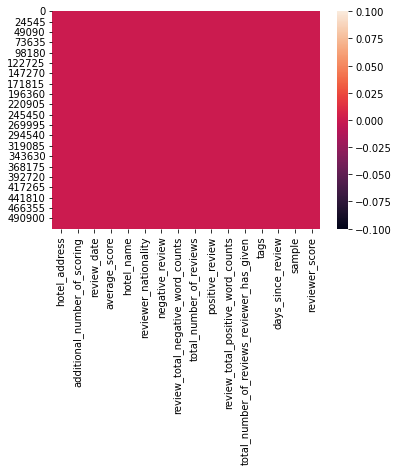

In [417]:
sns.heatmap(data.isnull())

In [418]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Из оставшихся признаков 8 являются числовыми, остальные не числовые. Тесктовые признаки ( а именно отзывы) могут содержать информацию, необходимую для предсказания рейтинга отделя, такую как качество номеров, качество обслуживания клиентов, расположение отеля, услуги, предосталвяемые отелем, поэтому текстовые признаки  можно преобразовать или выделить из них числовые, с которыми сможет работать модель машинного обучения.

Посмотрим на распределение признаков числовых признаков

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'sample'}>,
        <AxesSubplot:title={'center':'reviewer_score'}>, <AxesSubplot:>]],
      dtype=object)

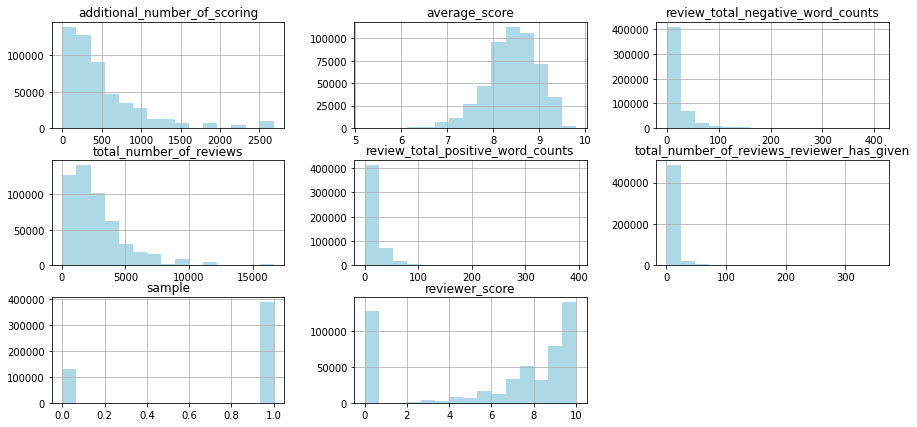

In [419]:
hist = data.hist(figsize=(15, 7), color='lightblue', bins=15)
hist

Распредление числовых признаков не является нормальным, в дальнейшем, после проектирования новых числовых признаков, посторно проверим данные на нормальность и в случае необходимости нормализуем их. 

# **2. Проектирование признаков**

Рассмотрим признак 'hotel_address', который содержит информацию о странах и городах, в которых расположены отели. 
Напишем функцию извлекающую страну, в которой находится отель, названия стран состоят из одного слова, за исключением United Kingdom 

In [420]:
def get_country(address):
    result = address.split()
    if 'Kingdom' in address:
        return ' '.join(result[-2:])
    else:
        return str(result[-1])

data['hotel_country'] = data['hotel_address'].apply(get_country)
print('Количество стран, в которых расположены отели:', data['hotel_country'].value_counts().count())

Количество стран, в которых расположены отели: 6


Найдем количество отелей, расположеных в странах 

In [421]:
data['hotel_country'].value_counts()

United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: hotel_country, dtype: int64

Функция, которая извлекает город, в котором расположен отель.

In [422]:
def get_city(address): 
    result = address.split()
    if 'Kingdom' in address:
        return ''.join(result[-5])
    else:
        return str(result[-2])

data['hotel_city'] = data['hotel_address'].apply(get_city)
print('Количество городов, в которых расположены отели в датасете:', data['hotel_city'].value_counts().count())


Количество городов, в которых расположены отели в датасете: 6


Найдем количество отелей, расположенных в городах 

In [423]:
data['hotel_city'].value_counts()

London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64

Наибольшее количество отелей сосредоточено в столице Великобритании - Лондоне

Так как мы создали 2 новых признака, содержащих страны и города, в которых расположены отели, в отдельные признаки, удалим признак с адресами отелей. 

In [424]:
data.drop(['hotel_address'], axis=1, inplace=True)

In [425]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

In [426]:
data.head(5)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,hotel_country,hotel_city
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,Milan
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,Amsterdam
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,Barcelona
3,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,0,0.0,Italy,Milan
4,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,0,0.0,Netherlands,Amsterdam


Данные, содержащиеся в признаках positive_review и negative_review, являются наиболее важными для построения модели.  Проанализаируем позитивные и негативные отзывы при помощи анализа тональности SentimentIntensityAnalyzer. 

In [427]:
sent_analyzer = SentimentIntensityAnalyzer()



Добавим столбцы в исходный датасет для хранения словарей polarity_score, а также получим данные  составных оценок. Отзывы в этом методе будут разделены на отрицательные, положительные и нейтральные.

In [428]:
data['scores_pos'] = data['positive_review'].apply(lambda positive_review: sent_analyzer.polarity_scores(positive_review))


In [429]:
data['scores_neg'] = data['negative_review'].apply(lambda negative_review: sent_analyzer.polarity_scores(negative_review))

In [430]:
data['pos_compound'] = data['scores_pos'].apply(lambda score_dict: score_dict['compound'])

In [431]:
data['neg_compound'] = data['scores_neg'].apply(lambda score_dict: score_dict['compound'])

Теперь соединение будет отображаться как отдельный столбец, и все значения больше нуля будут рассматриваться как положительный отзыв, а все значения меньше нуля будут рассматриваться как отрицательный отзыв.

In [432]:
data.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,tags,days_since_review,sample,reviewer_score,hotel_country,hotel_city,scores_pos,scores_neg,pos_compound,neg_compound
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,Milan,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...","{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...",0.9615,-0.0554
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,Amsterdam,"{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...","{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...",0.3400,-0.2960
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,Barcelona,"{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.6908,0.0000


Исходные признаки удалим.

In [433]:
data.drop(['positive_review', 'negative_review'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   review_total_positive_word_counts           515431 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 9   tags                                        515431 non-null  object 
 

 Преобразуем признак Выделим 30 самых популярных, а остальные объединим в 'Other'.

In [434]:
pop_nationality = data['reviewer_nationality'].value_counts().nlargest(30).index.to_list()

In [435]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in pop_nationality else 'other')

Создадим признаки дней, недель, месяцев и года из признака review_date и удалим его.

In [436]:
# приводим признак review_date к формату datetime. 

data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')


In [437]:
# выделяем признаки дней, недель, месяцев и года
data['review_day'] = data['review_date'].dt.day.astype(int)
data['review_weekday'] = data['review_date'].dt.dayofweek.astype(int)
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_year'] = data['review_date'].dt.year.astype(int)

In [438]:
data.drop(['review_date'], axis=1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   tags                                        515431 non-null  object 
 9   days_since_review                           515431 non-null  object 
 

Преобразуем признак tags

Напишем функцию для поиска всех тегов в признаке. Создадим признак stayed_nights

In [439]:
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,...,hotel_country,hotel_city,scores_pos,scores_neg,pos_compound,neg_compound,review_day,review_weekday,review_month,review_year
0,904,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,...,Italy,Milan,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...","{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...",0.9615,-0.0554,21,4,7,2017
1,612,8.6,Urban Lodge Hotel,Belgium,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,...,Netherlands,Amsterdam,"{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...","{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...",0.3400,-0.2960,12,0,12,2016
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,...,Spain,Barcelona,"{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.6908,0.0000,26,3,11,2015


# **3. Кодирование и преобразование признаков**.

Закодируем названия городов одинарным способом кодирования, так как городо всего 6.  В кодировании стран нет смысла, так как каждая страна представлена в рассматриваемых данных только одним городом. 

In [440]:
encoder = ce.OneHotEncoder(cols=['hotel_city'])
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['hotel_city'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   tags                                        515431 non-null  object 
 9   days_since_review                           515431 non-null  object 
 

Для  кодировки признака reviewer_nationality будем использовать бинарный способ кодирования, так как в данном признаке большое количество уникальных значений

In [441]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

data.drop(['reviewer_nationality'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   tags                                        515431 non-null  object 
 8   days_since_review                           515431 non-null  object 
 9   sample                                      515431 non-null  int64  
 

# **4. Отбор признаков**

In [442]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   sample                                      515431 non-null  int64  
 7   reviewer_score                              515431 non-null  float64
 8   pos_compound                                515431 non-null  float64
 9   neg_compound                                515431 non-null  float64
 

Посмотрим на распределение признаков числовых признаков после проектирования и преобразования признаков 

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>,
        <AxesSubplot:title={'center':'sample'}>,
        <AxesSubplot:title={'center':'reviewer_score'}>,
        <AxesSubplot:title={'center':'pos_compound'}>,
        <AxesSubplot:title={'center':'neg_compound'}>],
       [<AxesSubplot:title={'center':'review_day'}>,
        <AxesSubplot:title={'center':'review_weekday'}>,
        <AxesSubplot:title={'center':'review_month'}>,
        <AxesSubplot:title={'center':'review_year'}>,
        <AxesSubplot:title={'center':'hotel_city_1'}>],
       [<AxesSubplot:title={'center':'hotel_city_2'}>,
        <AxesSubplot:t

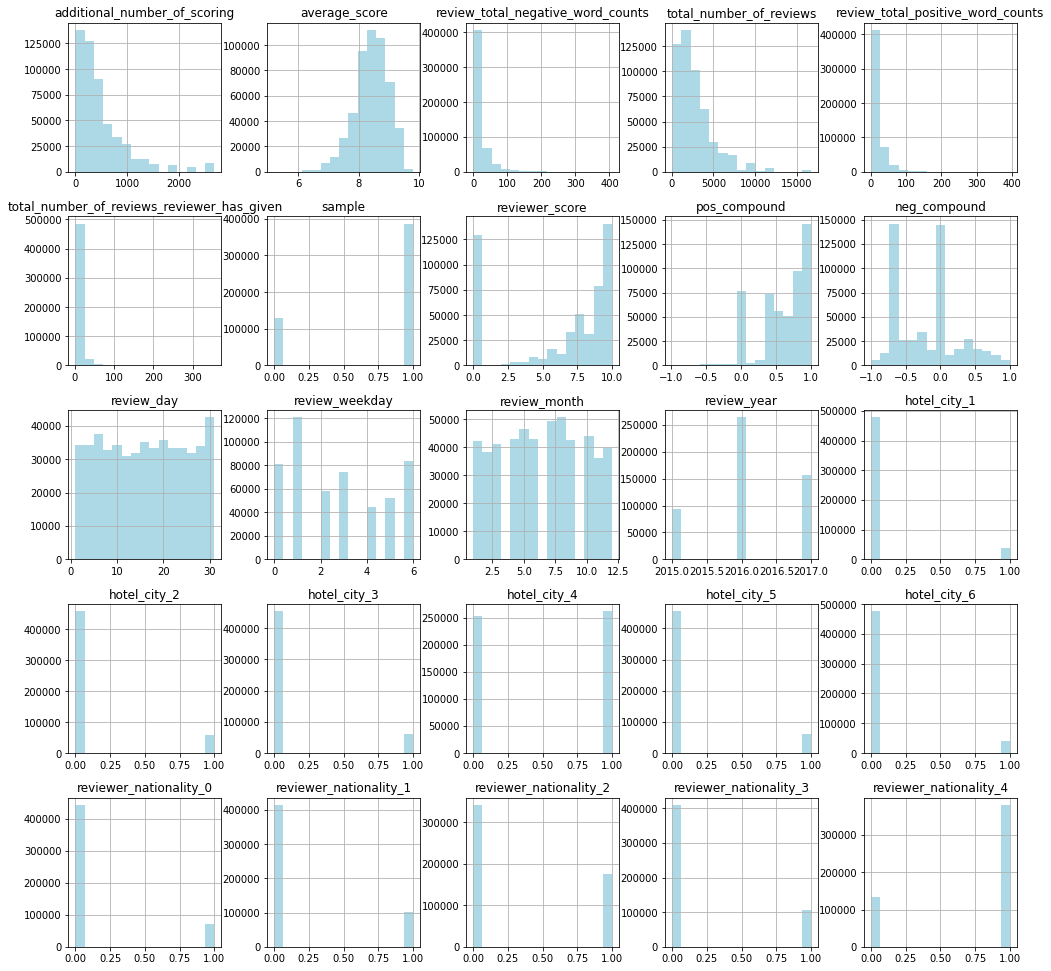

In [443]:
hist = data.hist(figsize=(17, 17), color='lightblue', bins=15)
hist

Распределение признаков не является нормальным, возможно за исключением признака average_score и так как на начальном этапе не очистили данне от выбросов применять будем нормализатор RobustScaler, потому что он не зависит от большого количества выбросов. 

Описательные статистики до нормализации

In [444]:
#data.describe()

In [445]:
# для нормализации, стандартизации
#from sklearn import preprocessing

# инициализируем нормализатор RobustScaler
#r_scaler = preprocessing.RobustScaler()
#col_names = list(data.columns)

# копируем исходный датасет
#data_r = r_scaler.fit_transform(data)

#data_r = pd.DataFrame(data_r, columns=col_names)

# смотрим описательные после нормализации статистики
#data_r.describe()

Нормализация ухудшала значение метрики MAPE. Поэтому от ее примения я откзалась. 

Построим тепловую корреляционную матрицу и проанализируем данные на наличие мультиколлинеарности
Данные для построения графика

<AxesSubplot:>

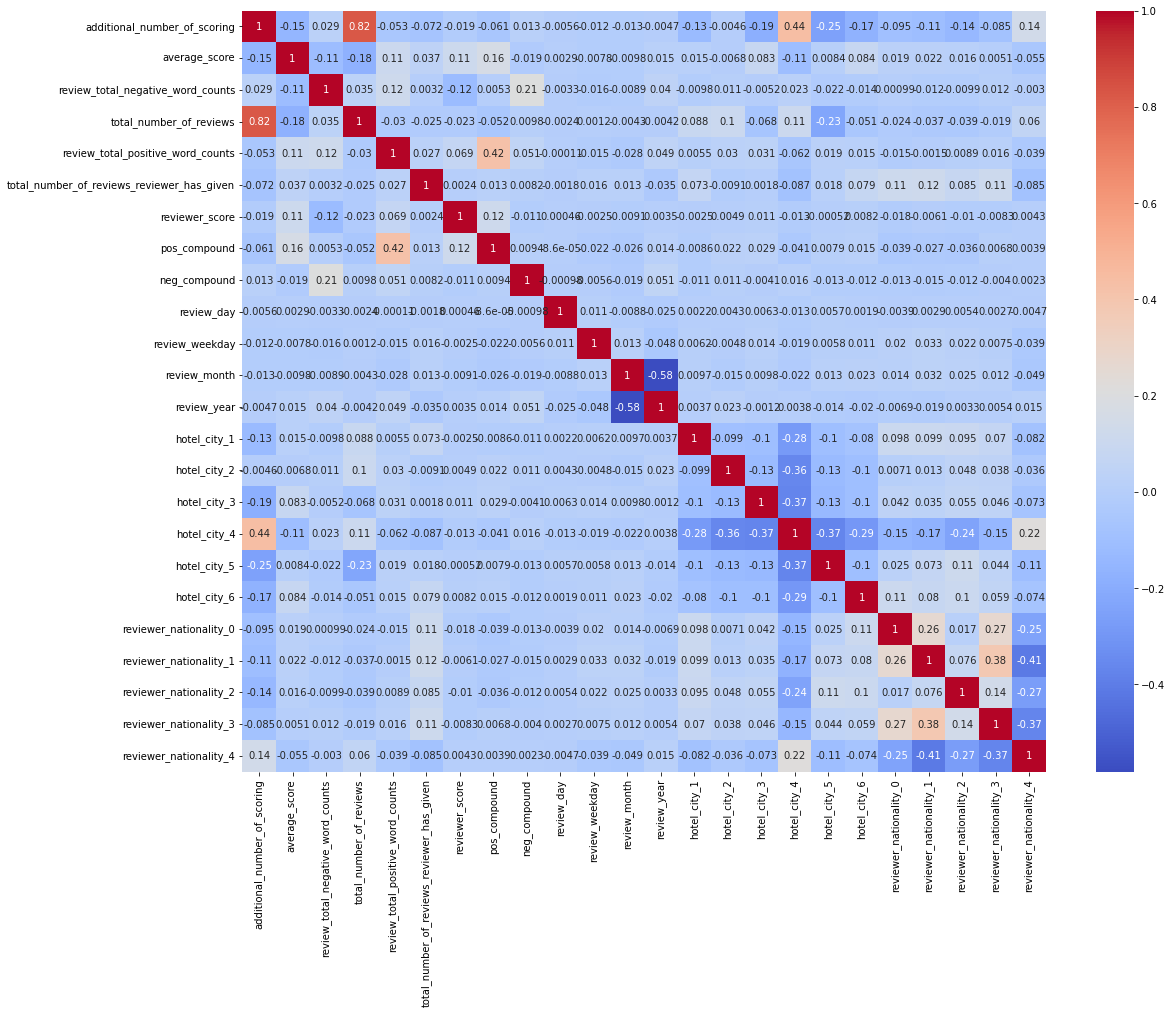

In [446]:
plt.rcParams['figure.figsize'] = (18,14)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True, cmap='coolwarm')

Высокий коэффициент корреляции имеют 2 признака: total_number_of_reviews (общее количество отзывов у отеля) и additional_number_of_scoring (количество оценок, без отзывов). Считаю, что данные признаки удалять не стоит до того, как оценим значимость этих признаков.

Разделим выборки на X и y

In [447]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

Разделим признаки на непрерывные и категориальные, чтобы оценить значисмость каждого признака.

In [448]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score', 'review_total_positive_word_counts','review_total_negative_word_counts',   
           'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'pos_compound', 'neg_compound']

# категориальные признаки
cat_cols = ['review_day', 'review_month', 'review_year', 'review_weekday', 'hotel_city_1', 'hotel_city_2', 'hotel_city_3',
            'hotel_city_4', 'hotel_city_5', 'hotel_city_6', 'reviewer_nationality_0', 'reviewer_nationality_1', 
            'reviewer_nationality_2',  'reviewer_nationality_3', 'reviewer_nationality_4',] 

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

<AxesSubplot:>

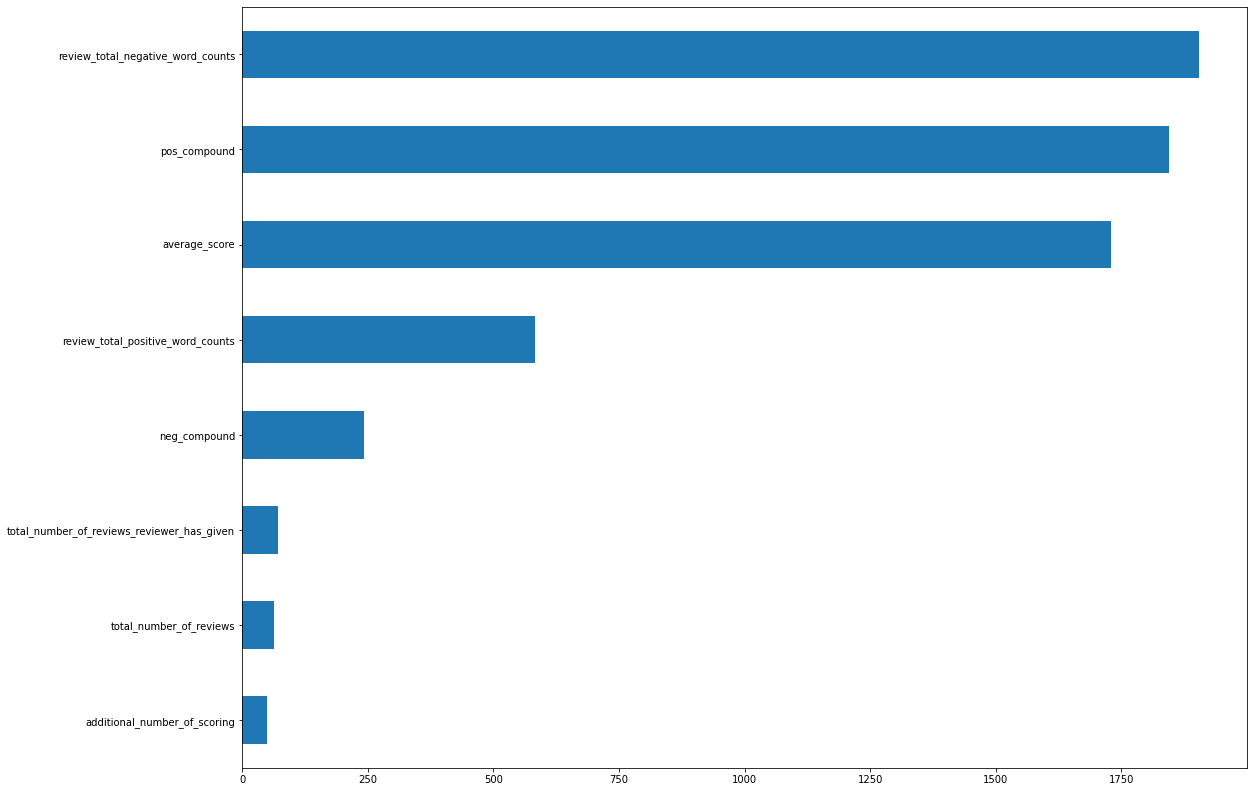

In [449]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

После проведения оценки значимости неприрывных признаков видим, что один пары признаков, имеющих высокий коэффициент корреляции additional_number_of_scoring имеет наименьшую значимость, пожтому его можно удалить. Также удалим признак 'total_number_of_reviews'. 

<AxesSubplot:>

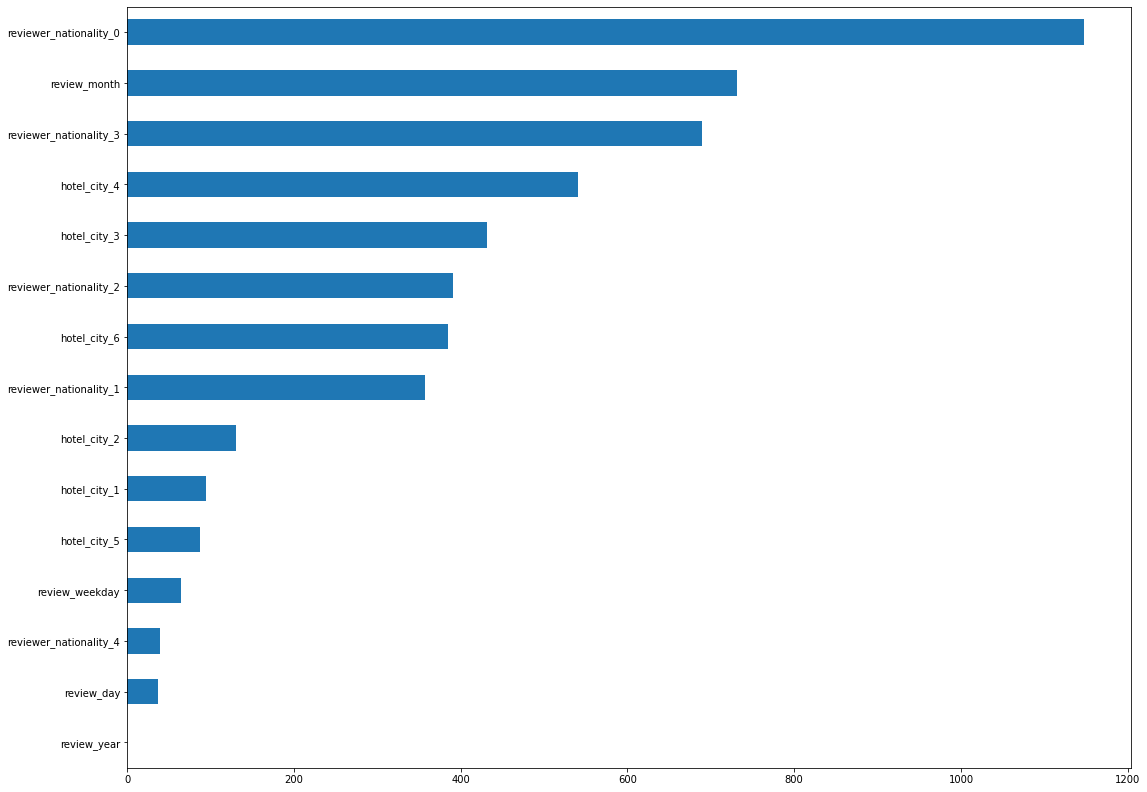

In [450]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Признаки review_day и review_year и  review_weekday оказывают минимальное влияние, их также удалим. 

In [451]:
data = data.drop(['additional_number_of_scoring', 'review_day', 'review_year', 'review_weekday', 'total_number_of_reviews'],axis=1)

In [452]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   review_total_positive_word_counts           515431 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 4   sample                                      515431 non-null  int64  
 5   reviewer_score                              515431 non-null  float64
 6   pos_compound                                515431 non-null  float64
 7   neg_compound                                515431 non-null  float64
 8   review_month                                515431 non-null  int64  
 9   hotel_city_1                                515431 non-null  int64  
 

# **5. Обучение модели**

In [453]:
 #pазбиваем датасет на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей) 

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

In [454]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [455]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 24), (386496, 24), (386496, 23), (309196, 23), (77300, 23))

In [456]:
# Импортируем необходимые библиотеки:
#from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [457]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [458]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [459]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8804103678309613


In [460]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) по метрике MAPE
# Данная метрика показывает среднее отклонение предсказанных значений от фактических в процентах
def MAPE(y_test, y_pred): 
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test))*100
print('MAPE:', (MAPE(y_test, y_pred)))

MAPE: 12.577621036418702


<AxesSubplot:>

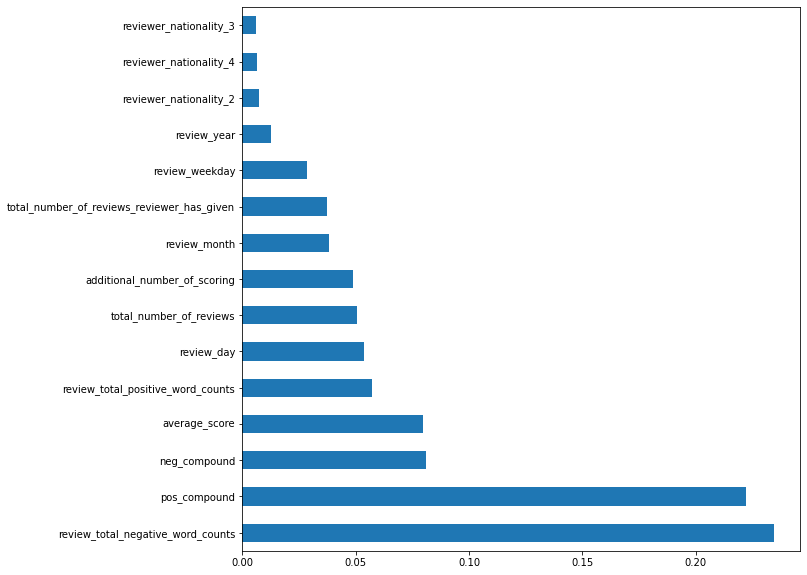

In [461]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [462]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,pos_compound,neg_compound,review_day,...,hotel_city_2,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
92258,617,8.8,0,2213,13,7,0.0,0.5859,-0.7096,13,...,0,0,1,0,0,0,0,0,0,1
84461,241,7.5,0,1287,10,1,0.0,0.8849,-0.7096,20,...,0,0,1,0,0,0,0,0,0,1
77758,256,8.4,220,2254,0,2,0.0,0.3400,0.7459,12,...,0,1,0,0,0,0,0,0,0,1
14889,512,8.0,15,2491,16,1,0.0,0.9588,-0.3412,12,...,0,0,1,0,0,0,0,0,0,1
78611,229,6.9,19,5742,10,1,0.0,0.8268,-0.5859,9,...,0,0,0,0,0,0,0,0,0,1
97801,167,8.6,26,1594,7,40,0.0,0.7269,0.0000,26,...,0,1,0,0,0,0,0,1,0,1
114839,187,8.8,3,750,3,4,0.0,0.5859,0.0000,21,...,0,0,1,0,0,0,0,0,0,1
58771,219,8.1,5,1116,3,1,0.0,0.5719,0.0000,31,...,0,0,1,0,0,0,1,0,1,0
1423,379,8.9,20,3774,3,9,0.0,0.6249,-0.4767,29,...,0,0,0,0,0,1,0,1,1,0
32492,1936,8.7,0,7491,12,1,0.0,0.8979,-0.7096,8,...,0,0,1,0,0,0,0,0,0,1


In [463]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [464]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [465]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.2s finished


In [466]:
predict_submission

array([8.797, 7.687, 8.753, ..., 8.431, 9.611, 6.862])

In [467]:
list(sample_submission)

['reviewer_score', 'id']

In [468]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.797,488440
1,7.687,274649
2,8.753,374688
3,9.761,404352
4,9.603,451596
5,9.106,302161
6,8.002,317079
7,7.846,13963
8,8.182,159785
9,7.651,195089
